In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# extraindo o zip
import os
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/office_not_office')

In [5]:
# definindo os paths no /tmp da virtual machine do Colab
base_dir = '/tmp/office_not_office/dataset'
train_dir = os.path.join(base_dir, 'training_set')
test_dir = os.path.join(base_dir, 'test_set')

In [7]:
# definindo set de treino
training_set = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
seed=101,
image_size=(400, 400),
batch_size=32)

Found 373 files belonging to 2 classes.


In [8]:
# definindo set de teste
validation_set = tf.keras.preprocessing.image_dataset_from_directory(
test_dir,
seed=101,
image_size=(400, 400),
batch_size=32)

Found 84 files belonging to 2 classes.


In [9]:
# testando se o set de treino veio certinho. o output correto deve ser ['office', 'not_office']
class_names = training_set.class_names
class_names

['not_office', 'office']

In [10]:
# obtendo um modelo de aleatorizacao de imagens para evitar overfit
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(400, 400, 3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

In [11]:
# CNN com Dropout e BatchNormalization para acelerar o treino

model = Sequential([
    data_augmentation,
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(filters=32,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Conv2D(filters=64,kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    tf.keras.layers.BatchNormalization(),  # não tenho certeza se esta linha deveria vir antes ou depois do Dropout
    Dense(1, activation='sigmoid')
])

In [12]:
# Compilando o modelo
model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [13]:
# Definindo callbacks para Early Stopping e para Checkpoints que salvam o melhor modelo
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='loss',
    mode='min',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=2),
             model_checkpoint_callback,
]

In [14]:
# Treinando o modelo

history = model.fit(training_set,validation_data=validation_set, epochs=600,callbacks=callbacks)

Epoch 1/600
12/12 [==============================] - 90s 7s/step - loss: 0.8880 - binary_accuracy: 0.5234 - val_loss: 4.2325 - val_binary_accuracy: 0.5238
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/600
12/12 [==============================] - 86s 7s/step - loss: 0.7525 - binary_accuracy: 0.5471 - val_loss: 2.3415 - val_binary_accuracy: 0.5238
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/600
12/12 [==============================] - 85s 7s/step - loss: 0.7841 - binary_accuracy: 0.5534 - val_loss: 0.8790 - val_binary_accuracy: 0.5238
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 4/600
12/12 [==============================] - 85s 7s/step - loss: 0.6730 - binary_accuracy: 0.6097 - val_loss: 0.8664 - val_binary_accuracy: 0.5238
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/600
12/12 [==============================] - 86s 7s/step - loss: 0.6621 - binary_accuracy: 0.6134 - val_loss: 0.6278 - val_binary_accuracy: 

In [15]:
# Plotando metricas
metrics_df = pd.DataFrame(history.history)

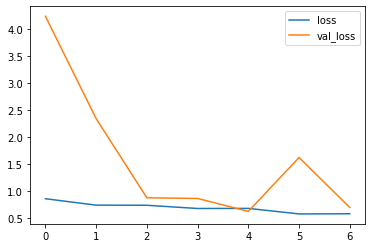

In [16]:
metrics_df[["loss","val_loss"]].plot();

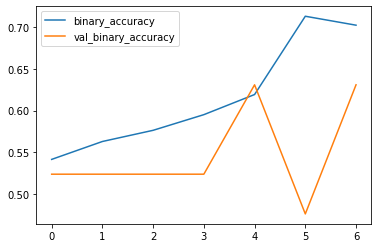

In [19]:
metrics_df[["binary_accuracy","val_binary_accuracy"]].plot();

In [18]:
# Avaliação do modelo
loss, accuracy = model.evaluate(validation_set)
print('Accuracy on test dataset:', accuracy) 

3/3 [==============================] - 5s 1s/step - loss: 0.7000 - binary_accuracy: 0.6310
Accuracy on test dataset: 0.6309523582458496
